In [1]:
!pip install joblib

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import glob
import time
import cv2

from sklearn.utils import shuffle


%matplotlib inline

In [3]:
from feature import *

cars, notcars = list_files(data_dir='./data')

print("Original - Car image count: {}, non-car image count: {}".format(len(cars), len(notcars)))

Original - Car image count: 8792, non-car image count: 8968


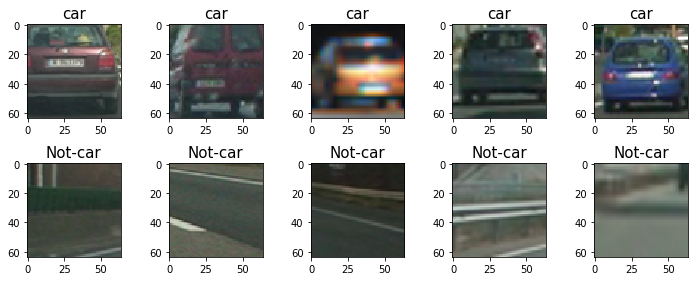

In [4]:
def show_sample(cars, notcars):
    r, c = (2, 5)
    
    f, ax = plt.subplots(r, c, figsize=(10, 4))
    f.tight_layout()
    
    ax = ax.ravel()

    # Make it reproducible
    np.random.seed(1)
    
    for i in range(0, c):
        idx = np.random.randint(0, 2000)

        ax[i].imshow(mpimg.imread(cars[idx]))
        ax[i].set_title("car", fontsize=15)

        ax[c + i].imshow(mpimg.imread(notcars[idx]))
        ax[c + i].set_title('Not-car', fontsize=15)
    
    plt.savefig('./output_images/car_not_car.png')
    plt.show()
    
show_sample(cars, notcars)

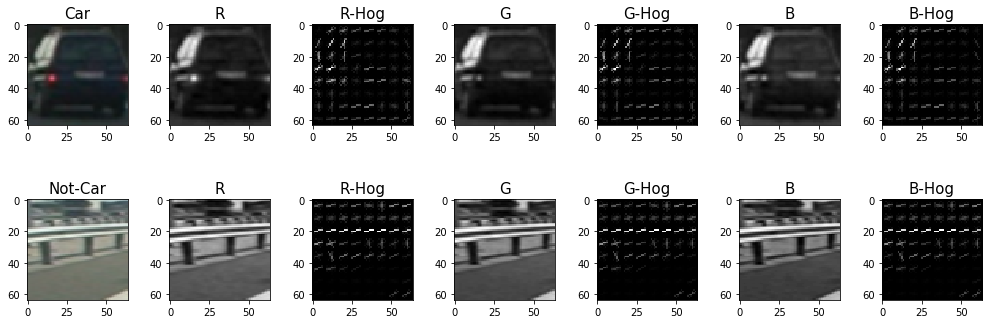

In [5]:
from feature import *

params = Params(color_space='YCrCb', hog_feat=True)

def show_hog_feature_sample(color_space, params):    
    car_image = mpimg.imread(cars[1150])
    notcar_image = mpimg.imread(notcars[1150])
    
    r, c = (2, 7)

    f, ax = plt.subplots(r, c, figsize=(14, 5))
    f.tight_layout()

    ax = ax.ravel()
    
    for i, img, title in zip(range(0, 2), [car_image, notcar_image], ['Car', 'Not-Car']):
        ax[i * c].imshow(img)
        ax[i * c].set_title(title, fontsize=15)
        
        img = convert_color_space(img, ''.join(color_space))
        
        for channel in range(0, 3):
            channel_image = img[:,:,channel]
            
            ax[i*c + channel*2 + 1].imshow(channel_image, cmap='gray')
            ax[i*c + channel*2 + 1].set_title("{}".format(color_space[channel]), fontsize=15)
            
            _, hog_image = get_hog_features(channel_image, orient=params.orient, 
                                         pix_per_cell=params.pix_per_cell,
                                         cell_per_block=params.cell_per_block,
                                         vis=True, feature_vec=True)
            ax[i*c + channel*2 + 2].imshow(hog_image, cmap='gray')
            ax[i*c + channel*2 + 2].set_title("{}-Hog".format(color_space[channel]), fontsize=15)
            
    plt.savefig('./output_images/HOG_{}.jpg'.format(''.join(color_space)))

show_hog_feature_sample(color_space=['R', 'G', 'B'], params=params)

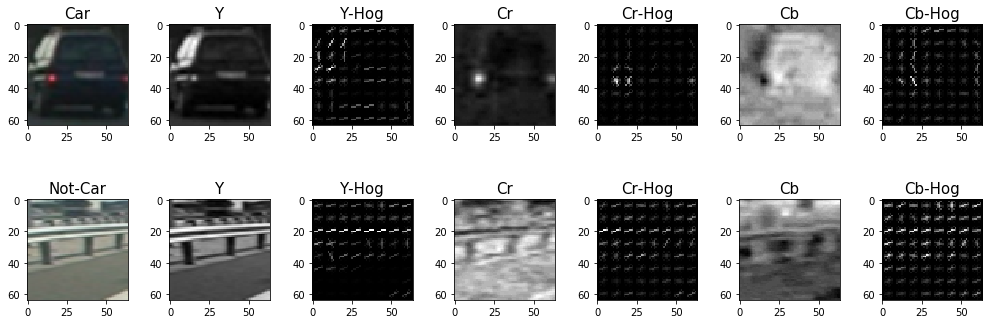

In [6]:
show_hog_feature_sample(color_space=['Y', 'Cr', 'Cb'], params=params)

In [7]:
from training import *

# set the sample size
# sample_size = min(len(cars), len(notcars))
# _cars = cars[0:sample_size]
# _notcars = notcars[0:sample_size]

params = Params(color_space='YCrCb', hog_feat=True)

X_train, X_test, y_train, y_test = prepare_dataset(cars, notcars, params, ratio=0.2)
X_scaler, X_train, X_test = normalize(X_train, X_test)

print('Using:', params.orient,'orientations', params.pix_per_cell, 
      'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t=time.time()
svc = train_svc_model(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1993s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Batch computation too fast (0.0723s.) Setting batch_size=10.
[Parallel(n_jobs=10)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1966s.) Setting batch_size=20.
[Parallel(n_jobs=10)]: Done  98 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 228 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done 469 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 769 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 1109 tasks      | elapse

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
7.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


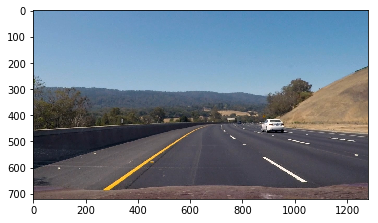

In [90]:
from detection import *

from joblib import Parallel,delayed

from scipy.ndimage.measurements import label
from skimage.filters import gaussian
from joblib import Parallel,delayed

from feature import *

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, ystart, ystop, scale, svc, X_scaler, params):
    img_tosearch = img[ystart:ystop, xstart:, :]
        
    # apply color conversion if other than 'RGB'
    ctrans_tosearch = convert_color_space(img_tosearch, params.color_space)
       
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
       
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // params.pix_per_cell) - params.cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // params.pix_per_cell) - params.cell_per_block + 1 
    nfeat_per_block = params.orient*params.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // params.pix_per_cell) - params.cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    if params.hog_feat == True:
        # select colorspace channel for HOG 
        if params.hog_channel == 'ALL':
            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]
        else: 
            ch1 = ctrans_tosearch[:,:,params.hog_channel]

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)

        if params.hog_channel == 'ALL':
            hog2 = get_hog_features(ch2, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, params.orient, params.pix_per_cell, params.cell_per_block, feature_vec=False)

    bbox_list=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            spatial_features = []
            hist_features = []
            hog_features = []
            
            if params.hog_feat == True:
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

                if params.hog_channel == 'ALL':
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog_feat1

            xleft = xpos*params.pix_per_cell
            ytop = ypos*params.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if params.spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=params.spatial_size)
                
            if params.hist_feat == True:
                hist_features = color_hist(subimg, nbins=params.hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            test_prediction = svc.predict(test_features)
            confidence = svc.decision_function(test_features)

            if test_prediction == 1 and confidence > 0.7:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)                
                
                bbox_list.append((
                    (xstart + xbox_left, ytop_draw+ystart),
                    (xstart + xbox_left+win_draw,ytop_draw+win_draw+ystart)
                ))
    return bbox_list

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        w = bbox[1][0] - bbox[0][0]
        h = bbox[1][1] - bbox[0][1]
        area = w * h
        
        draw = False
        if bbox[1][1] >= 550 and area > 4000:
            draw = True
        elif bbox[1][1] >= 450 and area > 1000:
            draw = True

        if draw == True:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

class CarDetector:
    def __init__(self, params, svc, X_scaler, scales, threshold):
        self.params = params
        self.svc = svc
        self.X_scaler = X_scaler
        self.scales = scales
        self.threshold = threshold

    def detect_cars(self, image):
        new_img = np.copy(image)
        bbox_list = []            

        # Search all scales in parallel
        tmp = Parallel(n_jobs=len(self.scales))(delayed(find_cars)(image, 0, 400, 656,
                                                                           scale, self.svc, self.X_scaler, self.params) for scale in self.scales)

        [bbox_list.extend(bboxes) for bboxes in tmp]        
        
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, bbox_list)
        
        heat = gaussian(heat, 5)      
        heat = apply_threshold(heat, self.threshold)

        # Find final boxes from heatmap using label function
        labels = label(heat)        
                          
        new_img = draw_labeled_bboxes(new_img, labels)
        
        return new_img

    
scales = [ 1.0, 1.5, 3.0 ]   
car_detector = CarDetector(params, svc, X_scaler, scales, threshold=4)
    
image = read_image('./test_images/test3.jpg')
img = car_detector.detect_cars(image)
plt.imshow(img)

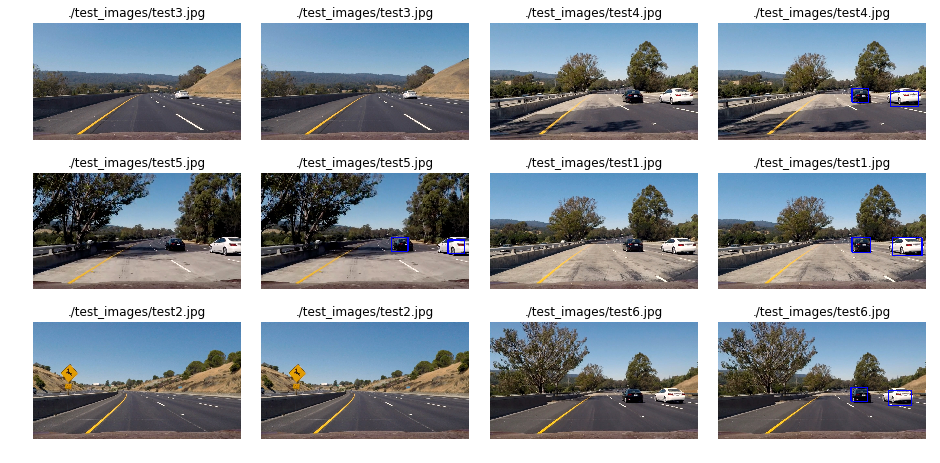

In [91]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 4, figsize=(16,8))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = read_image(im)

    axs[i * 2].imshow(image)
    axs[i * 2].set_title(im)
    axs[i * 2].axis('off')
    
    axs[i * 2 + 1].imshow(car_detector.detect_cars(image))
    axs[i * 2 + 1].set_title(im)
    axs[i * 2 + 1].axis('off')

In [11]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [92]:
car_detector = CarDetector(params, svc, X_scaler, scales, threshold=15)

output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(car_detector.detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


 97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

CPU times: user 2.37 s, sys: 173 ms, total: 2.54 s
Wall time: 39.2 s


In [93]:
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(25,30)
video_clip = clip.fl_image(car_detector.detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [20:55<00:00,  1.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 1min 16s, sys: 4.62 s, total: 1min 21s
Wall time: 20min 56s


In [ ]:
# output = 'result6.mp4'
# clip = VideoFileClip("project_video.mp4").subclip(30,35)
# video_clip = clip.fl_image(car_detector.detect_cars)
# %time video_clip.write_videofile(output, audio=False)

In [ ]:
# output = 'result7.mp4'
# clip = VideoFileClip("project_video.mp4").subclip(35,40)
# video_clip = clip.fl_image(car_detector.detect_cars)
# %time video_clip.write_videofile(output, audio=False)

In [78]:
output = 'result8.mp4'
clip = VideoFileClip("project_video.mp4").subclip(40,43)
video_clip = clip.fl_image(car_detector.detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result8.mp4
[MoviePy] Writing video result8.mp4


 99%|█████████▊| 75/76 [00:58<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result8.mp4 

CPU times: user 2.27 s, sys: 331 ms, total: 2.6 s
Wall time: 59.7 s


## 